In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Загрузка датасета
data = pd.read_csv('Walmart.csv', header=0, index_col=1, parse_dates=True, dayfirst=True)
data.drop(['Store','Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], axis=1, inplace=True)

# Вывод первых нескольких строк датасета
# data.head()
data=data.iloc[:250, :]
data.head()
# data.info()


,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


In [2]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
from statsmodels.tsa.seasonal import seasonal_decompose
# Аддитивная модель
def plot_decompose(data, model='add'):
    result_add = seasonal_decompose(data, model = 'add')
    fig = result_add.plot()
    fig.set_size_inches((10, 8))
    # Перерисовка
    fig.tight_layout()
    plt.show()
    
# Тренд - это тенденция, направление временного ряда.
# Сезонность показывает влияние периодичности (день недели, время года и т.д.), 
# фактически определяет "колебание" временного ряда вокруг тренда.
# Шум - это случайная составляющая ряда.

In [3]:
# plot_decompose(data=data['Weekly_Sales'], model='add')

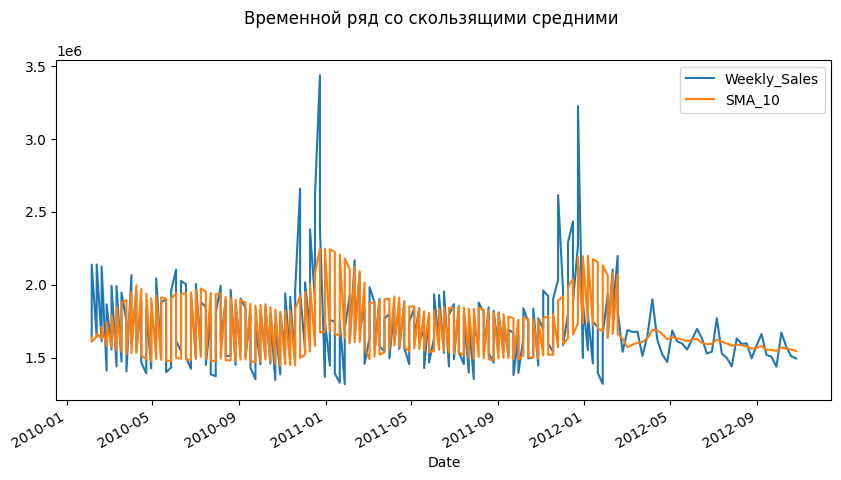

In [4]:
from matplotlib import pyplot
data_copy = data.copy()
# Простое скользящее среднее (SMA)
data['SMA_10'] = data['Weekly_Sales'].rolling(10, min_periods=1).mean()
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Временной ряд со скользящими средними')
data.plot(ax=ax, legend=True)
pyplot.show()

In [5]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Целочисленная метка шкалы времени 
xnum = list(range(data.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = data['Weekly_Sales'].values
train_size = int(len(Y) * 0.8)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]
history_es = [x for x in train]

In [6]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [7]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)

                try:
                    print(p,d,q)
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [8]:
import warnings
warnings.filterwarnings('ignore')
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(data_copy.values, p_values, d_values, q_values)

0 0 0
ARIMA(0, 0, 0) MSE=154373914512.782
0 0 1
ARIMA(0, 0, 1) MSE=114751567055.630
0 0 2
ARIMA(0, 0, 2) MSE=99408403364.632
0 1 0
ARIMA(0, 1, 0) MSE=104820983909.260
0 1 1
ARIMA(0, 1, 1) MSE=91892798224.734
0 1 2
ARIMA(0, 1, 2) MSE=90415239457.677
0 2 0
ARIMA(0, 2, 0) MSE=289595337834.266
0 2 1
ARIMA(0, 2, 1) MSE=105411568273.502
0 2 2
ARIMA(0, 2, 2) MSE=96694848664.186
1 0 0
ARIMA(1, 0, 0) MSE=95448833319.634
1 0 1
ARIMA(1, 0, 1) MSE=87514306366.975
1 0 2
ARIMA(1, 0, 2) MSE=88767412872.038
1 1 0
ARIMA(1, 1, 0) MSE=94643940481.177
1 1 1
ARIMA(1, 1, 1) MSE=87260039885.876
1 1 2
ARIMA(1, 1, 2) MSE=96515688695.776
1 2 0
ARIMA(1, 2, 0) MSE=174348798062.910
1 2 1
ARIMA(1, 2, 1) MSE=97980707342.453
1 2 2
ARIMA(1, 2, 2) MSE=97764304251.061
2 0 0
ARIMA(2, 0, 0) MSE=90676410059.249
2 0 1
ARIMA(2, 0, 1) MSE=86948017066.059
2 0 2
ARIMA(2, 0, 2) MSE=89113657108.293
2 1 0
ARIMA(2, 1, 0) MSE=94791807339.617
2 1 1
ARIMA(2, 1, 1) MSE=86548319806.281
2 1 2
ARIMA(2, 1, 2) MSE=83509010767.313
2 2 0
ARIM

In [9]:
# Параметры модели (p,d,q) p q d — целые числа, задающие порядок модели, d=0 -> ARMA
arima_order = (8,1,2)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])
# Вычисление метрики RMSE
error_arima = mean_squared_error(test, predictions_arima, squared=False)

In [10]:
# Формирование предсказаний
predictions_es = list()
for t in range(len(test)):
    model_es = ExponentialSmoothing(history_es)
    model_es_fit = model_es.fit()
    yhat_es = model_es_fit.forecast()[0]
    predictions_es.append(yhat_es)
    history_es.append(test[t])
# Вычисление метрики RMSE
error_es = mean_squared_error(test, predictions_es, squared=False)

# Ошибка прогноза
np.mean(Y), error_arima, error_es

(1717763.14564, 234821.12530211356, 257132.0649427457)

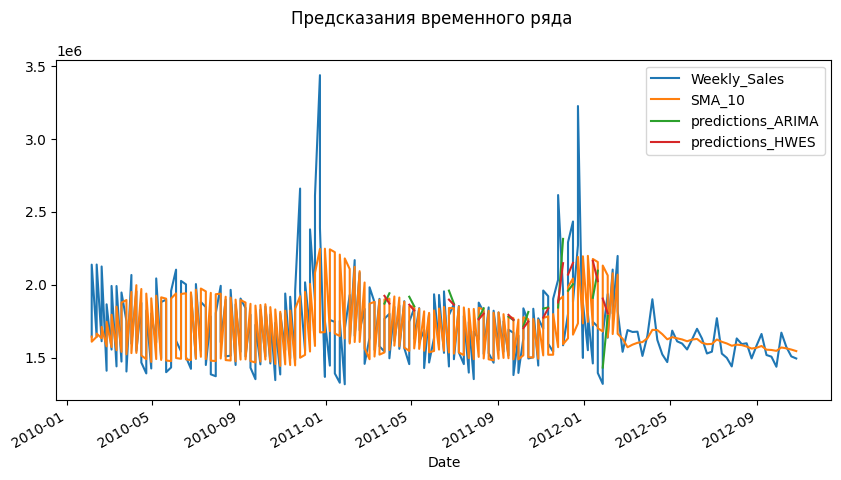

In [11]:
# Записываем предсказания в DataFrame
data['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)
data['predictions_HWES'] = (train_size * [np.NAN]) + list(predictions_es)
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
data.plot(ax=ax, legend=True)
pyplot.show()

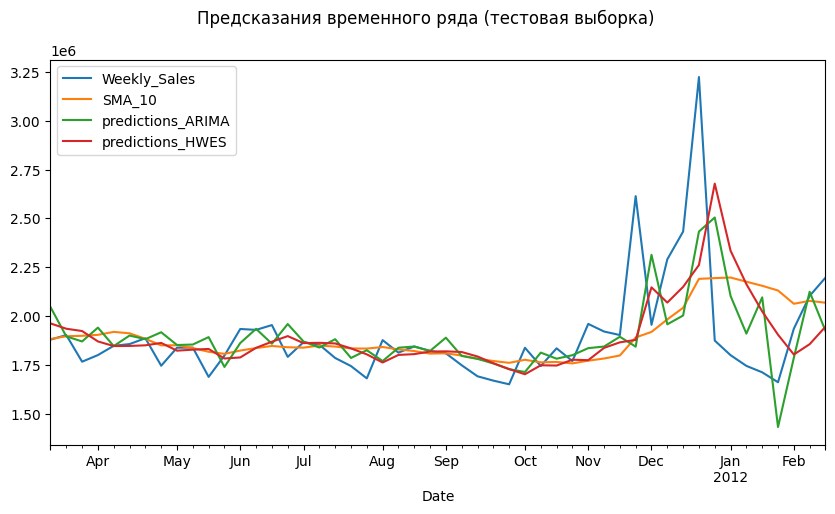

In [12]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data[train_size:].plot(ax=ax, legend=True)
pyplot.show()